## The Mystery of being broke by month end

This exploratory data analysis is to see why do I go broke before the end of each month. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from yaml import safe_load
from warnings import filterwarnings

filterwarnings('ignore')

CUSTOM FUNCTIONS

In [2]:
with open("config_bank.yml",'r') as f:
    config = safe_load(f)
    
date_cols = config.get('date_columns')
upi_platforms = config.get('upi_platform')
months = config.get("months")
expense_cols = config.get("expense_columns")

In [3]:
def detect_transaction(remark):
        
    patterns = config['pattern']
        
    for k,v in patterns.items():
        try:
            match=  re.search(v,remark)
            if match:
                return k
        except Exception as e:
            pass
    return None

def get_upi_platform(remark):    
    
    for k,v in upi_platforms.items():
        try:
            match=  re.search(k,remark)
            if match:
                return v
        except Exception as e:
            print(remark)
    return None   


In [4]:
data = pd.read_excel("data.xlsx",sheet_name="Sheet1")
data = data.drop(["S No."],axis=1)
data.head()

,Value Date,Transaction Date,Transaction Remarks,Withdrawal Amount,Deposit Amount,Balance
0,01/04/2021,02/04/2021,UPI/109109474229/test/jayantighosh66@/Punjab N...,1.0,0.0,288408.34
1,01/04/2021,02/04/2021,UPI/109143328898/Oid202104010910/paytm-2354160...,176.0,0.0,288232.34
2,02/04/2021,02/04/2021,BIL/BPAY/000081957525/SBI MUTUAL/SBDIRECT-5965...,4000.0,0.0,284232.34
3,02/04/2021,02/04/2021,BIL/BPAY/000081964632/AXIS MUTUA/AXDIRECT-E144...,3000.0,0.0,281232.34
4,02/04/2021,02/04/2021,UPI/109272170475/Oid13163152716@/paybil3066@pa...,49.0,0.0,281183.34


Value Data: The value date refers to the date when the transaction took place. <br>
Transaction Date: The transaction date is the date when the bank posts it in your account.

### Feature Engineering

In [5]:
# Convert to datetime.
# date_cols = ["Value Date","Transaction Date"]
data[date_cols] = data[date_cols].apply(pd.to_datetime)

## New Columns:
data["Day"] = data["Transaction Date"].dt.strftime('%d')
data["Month"] = data["Transaction Date"].dt.month_name()

# Transaction Type
data["tnx_type"] = data["Transaction Remarks"].apply(detect_transaction)

# UPI platform
data["upi_platform"] = data["Transaction Remarks"].apply(get_upi_platform)

data.head()

,Value Date,Transaction Date,Transaction Remarks,Withdrawal Amount,Deposit Amount,Balance,Day,Month,tnx_type,upi_platform
0,2021-01-04,2021-02-04,UPI/109109474229/test/jayantighosh66@/Punjab N...,1.0,0.0,288408.34,04,February,UPI,None
1,2021-01-04,2021-02-04,UPI/109143328898/Oid202104010910/paytm-2354160...,176.0,0.0,288232.34,04,February,UPI,Paytm
2,2021-02-04,2021-02-04,BIL/BPAY/000081957525/SBI MUTUAL/SBDIRECT-5965...,4000.0,0.0,284232.34,04,February,External Mutual Fund,None
3,2021-02-04,2021-02-04,BIL/BPAY/000081964632/AXIS MUTUA/AXDIRECT-E144...,3000.0,0.0,281232.34,04,February,External Mutual Fund,None
4,2021-02-04,2021-02-04,UPI/109272170475/Oid13163152716@/paybil3066@pa...,49.0,0.0,281183.34,04,February,UPI,Paytm


### Usage of UPI Platforms

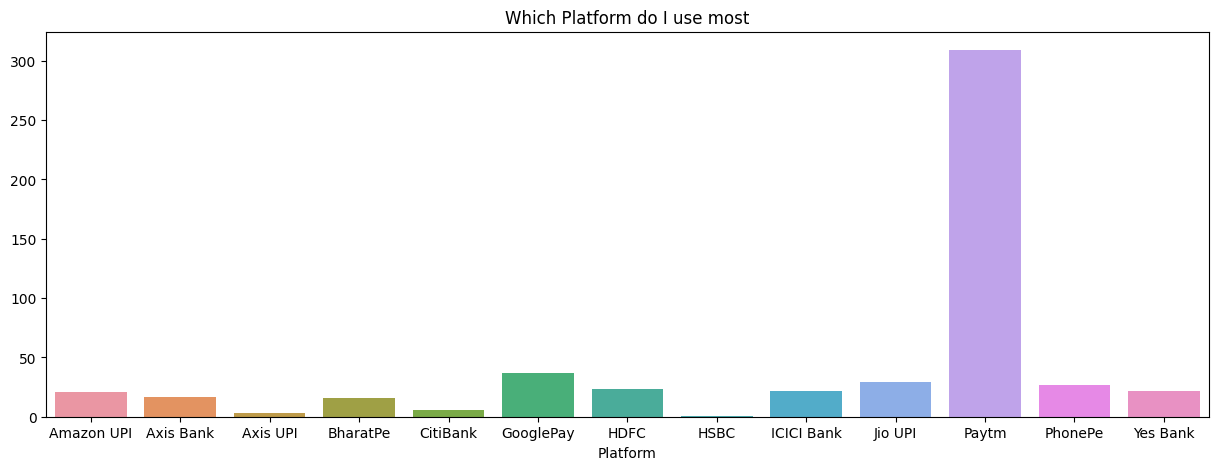

In [23]:
plt.figure(figsize=(15,5))
platforms = sorted(list(set(upi_platforms.values())))
sns.countplot(x=data["upi_platform"],order=platforms)
plt.title("Which Platform do I use most")
plt.ylabel("")
plt.xlabel("Platform")
plt.show();

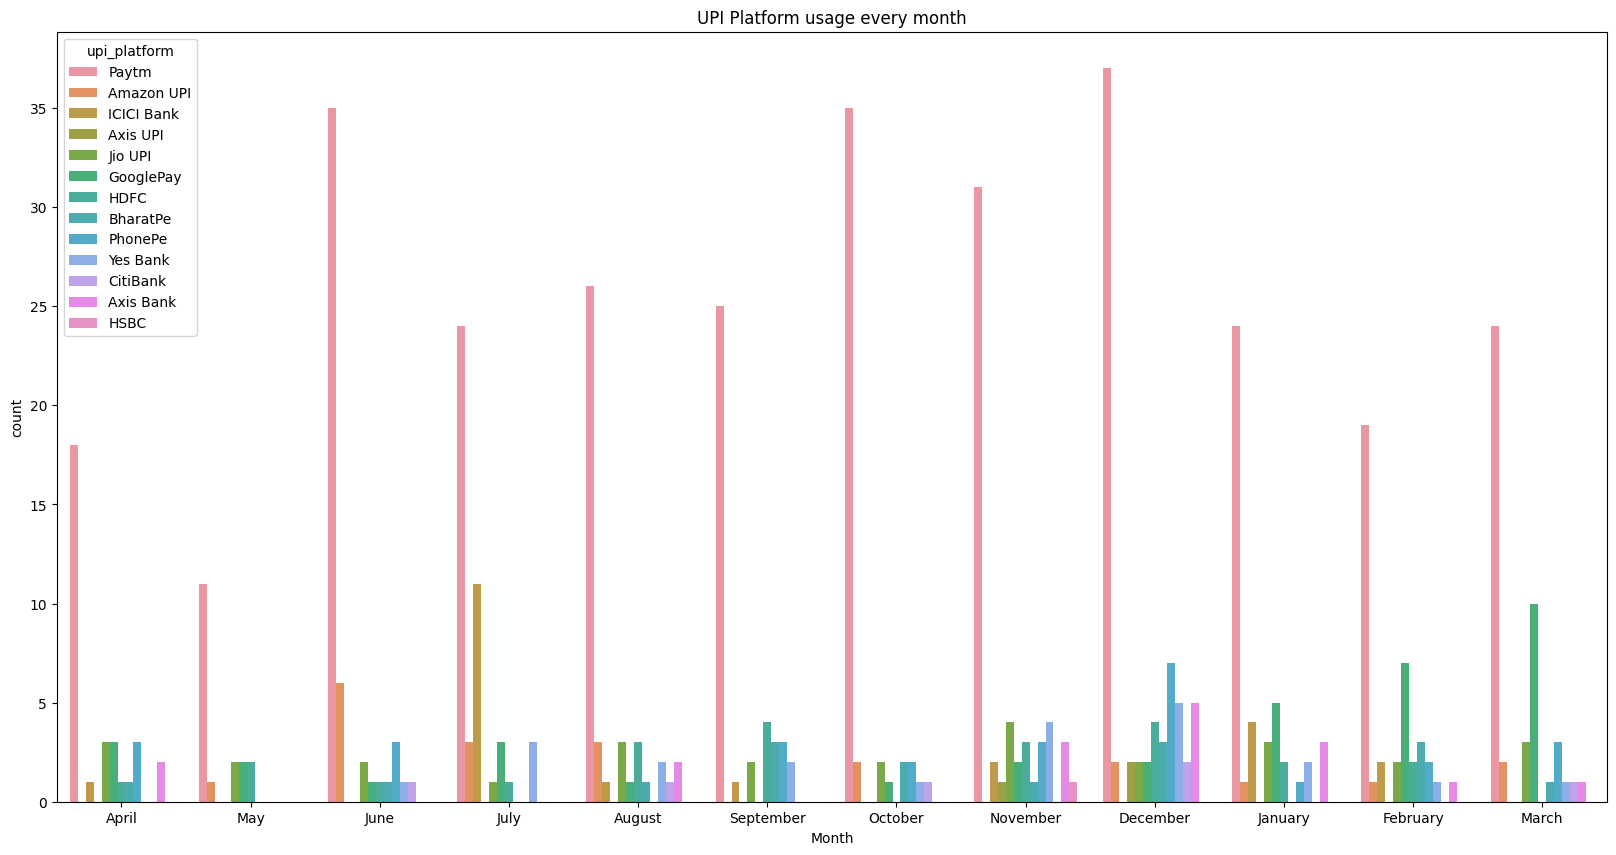

In [43]:
plt.figure(figsize=(20,10))
sns.countplot(x='Month',data=data,hue='upi_platform',order=months)
plt.title("UPI Platform usage every month")
plt.show();

## Expense Analysis

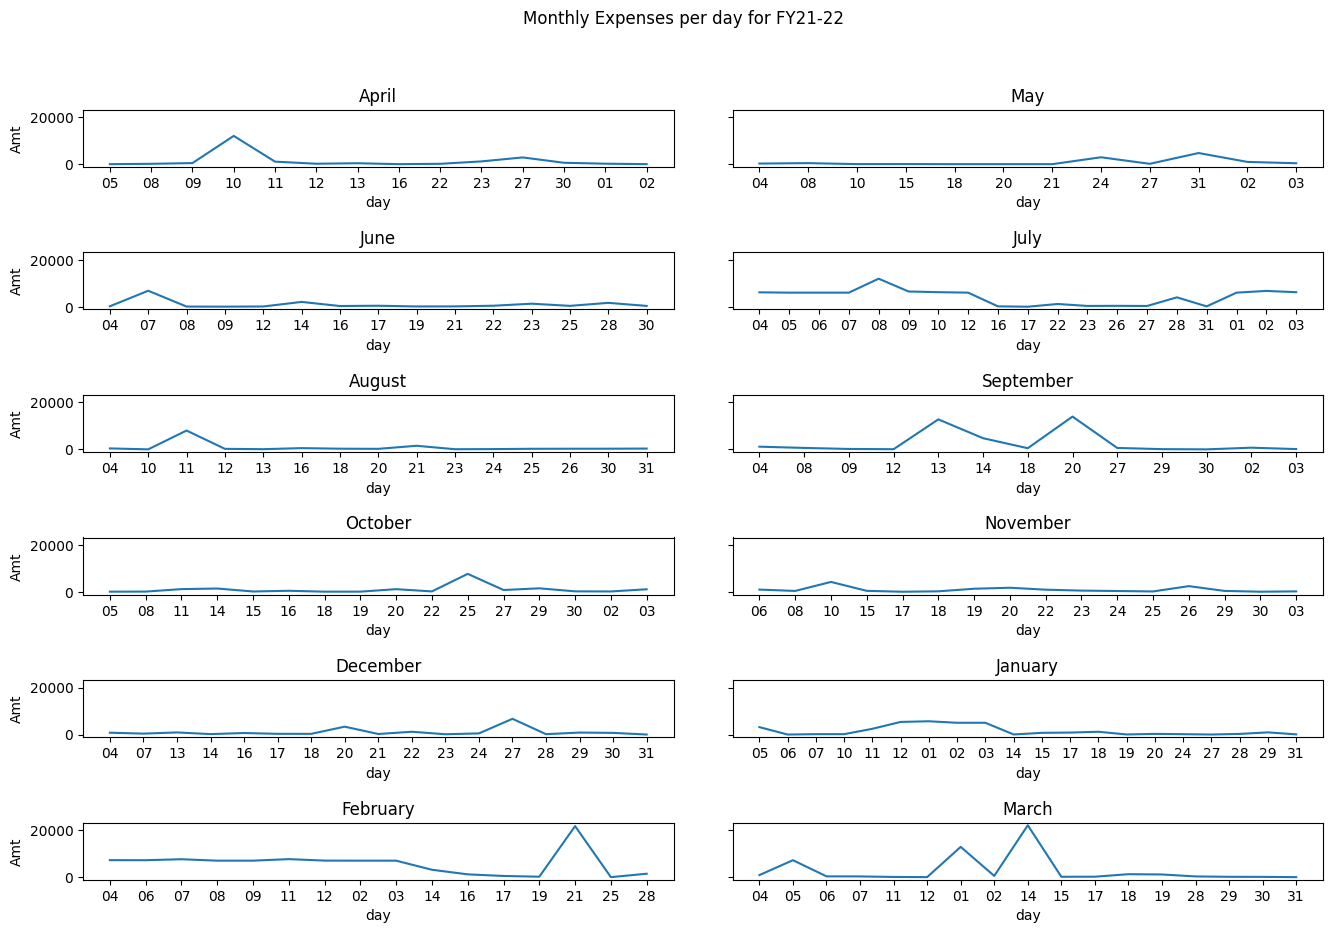

In [7]:
exp_df = data[expense_cols]

df = exp_df.groupby(["Transaction Date"])["Withdrawal Amount"].sum().reset_index()
df["day"] = df["Transaction Date"].dt.strftime('%d')
df['month'] = df["Transaction Date"].dt.month_name()

fig, ax = plt.subplots(nrows=6, ncols=2,figsize=(16,10),sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=1.5)

for i,ax in enumerate(ax.flatten()):
    if i <= 12:        
        sns.lineplot(x='day', y='Withdrawal Amount',data=df[df["month"]==months[i]],ax=ax)
        ax.set_title(months[i])
        ax.set_ylabel("Amt")
    else:
        ax.set_visible(False)
        
plt.suptitle("Monthly Expenses per day for FY21-22")
plt.show()

---

What kind of expenses do I occur the most? <br>
- For this I will be binning the expenses into smaller bins
- Outliers will be removed


In [8]:
exp_df = data[expense_cols]

#Since my mutual funds investments are not really expenses, I will be removing them.
exp_df = exp_df.loc[~(exp_df["tnx_type"] == "External Mutual Fund") | (exp_df["tnx_type"] == "Internal Mutual Fund")]
exp_df.head()

,Transaction Date,Day,Month,Withdrawal Amount,tnx_type
0,2021-02-04,04,February,1.0,UPI
1,2021-02-04,04,February,176.0,UPI
4,2021-02-04,04,February,49.0,UPI
5,2021-03-04,04,March,400.0,ATM
6,2021-03-04,04,March,130.0,UPI


In [9]:
sns.boxplot(y=exp_df["Wit"])

KeyError: 'Wit'